In [2]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

## Group Assignment
### Team Number: 03
### Team Member Names: Sherry, Kelly, Ifan
### Team Strategy Chosen: SAFE

### Introduction 

Our safe portfolio generator follows the strategy to have two portfolios, before combining them altogether using the Monte Carlo algorithm. The first portfolio contains a number of stocks with the lowest betas and standard deviation, computed using a point system that will be explained further later on. The second portfolio contains a number of stocks that are negatively correlated to help offset any fluctuations. We also account for diversification, ensuring that there are not too many industries dominating the portfolio, to further reduce overall risk. We finally find the combined portfolio weighting using Monte Carlo. 

To start, we will filter through the given list of stocks to drop any stocks that do not meet our requirements. 

In [36]:
max_stocks = 25 #The total number of stocks we can possibly have
tickers_df = pd.read_csv('Tickers_Example.csv')
#When the CSV file is read, it takes the first ticker and makes it the name of the column, so we need to extract it
tickers_list = list(tickers_df.columns)
#Now add the rest of the tickers in after it:
tickers_list += tickers_df.iloc[:, 0].tolist()
tickers_num = len(tickers_list)

#Dates to pull closing data from, change as needed
start_date = '2020-01-01'
end_date = '2022-01-02'

# Dictionary of all the stocks
stocks_dict = {}
stocks_full_info = {}

# Function produces the daily closing prices of a stock
def get_closing_prices(ticker, start, end):
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start, end=end) #Daily
    return hist.Close

for i in range (tickers_num):
    stocks_dict[tickers_list[i]] = get_closing_prices(tickers_list[i], start_date, end_date)
    stocks_full_info[tickers_list[i]] = yf.Ticker(tickers_list[i])

# Create DataFrame
all_prices = pd.DataFrame(stocks_dict)

tickers_list_temp = tickers_list.copy()
#Some tickers are delisted, so we drop those columns entirely
for i in range (tickers_num):
    if all_prices[tickers_list[i]].isnull().all():
        all_prices.drop(columns=[tickers_list[i]], inplace=True)
        tickers_list_temp.remove(tickers_list[i]) #Getting rid of the tickers from our list too to match
        stocks_full_info.pop(tickers_list[i]) #Do the same to the dictionary of yfinance ticker objects

tickers_list = tickers_list_temp.copy()
tickers_num = len(tickers_list)

#Drop the rows at the bottom of the DataFrame where only a few stocks have values and where the dates are strange
all_prices = all_prices.dropna() 

- AGN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- PCLN: No data found for this date range, symbol may be delisted
- RTN: No data found, symbol may be delisted
- TWX: No data found for this date range, symbol may be delisted


In [ ]:
#Drop the rows at the bottom of the DataFrame where only a few stocks have values and where the dates are strange
all_prices = all_prices.dropna() 

print(tickers_list)

#Display the entire DataFrame, so that we can manually check to make sure the values are sensible
#using threading 
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(all_prices)

In [37]:
# Remove invalid stocks per assignment requirement (ones outside of the U.S & ones with average monthly volume of less than 200,000 shares)

df_diff = pd.DataFrame()


def filter_market(df):
    df_transposed = df.T
    mkt_lst = []
    
    for i in range(len(df_transposed)):
        # Populate market list
        temp = stocks_full_info[tickers_list[i]]
        mkt_lst.append(temp.info['market'])
    
    df_transposed['Market'] = mkt_lst
    
    # Drops the stocks in markets that are not in the U.S
    df_transposed.drop(df_transposed[df_transposed.Market != "us_market"].index, inplace=True)
    df_transposed = df_transposed.drop('Market', axis=1)
    return_df = df_transposed.T

    # Tracks the indices of the values that were dropped
    df_diff = pd.concat([df,return_df]).drop_duplicates(keep=False)

    return return_df

# Drops the stocks with volumes less than average monthly volume of 200,000
def filter_volume(df):

    start = "2022-01-01"
    end = "2022-10-31"

    df_transposed = df.T
    volume_lst = []

    for i in range(len(df_transposed)):
        ticker_hist = stocks_full_info[tickers_list[i]].history(start=start, end=end)
        volume_hist = ticker_hist.loc[(ticker_hist.index >= pd.to_datetime(start)) & (ticker_hist.index <= pd.to_datetime(end))]
        volume_lst.append(volume_hist['Volume'].mean()*30)

    # Drops the stocks with volumes less than average monthly volume of 200,000
    df_transposed["Volume"] = volume_lst

    df_transposed.drop(df_transposed[df_transposed.Volume < 200000].index, inplace=True)
    df_transposed = df_transposed.drop('Volume', axis=1)
    return_df = df_transposed.T

    # Tracks the indices of the values that were dropped
    df_diff = pd.concat([df,return_df]).drop_duplicates(keep=False)

    return return_df


# Drops stocks with more than specified number of NaN values
max_number_of_nans = 20
all_prices = all_prices.loc[:, (all_prices.isnull().sum(axis=0) <= max_number_of_nans)]


## Beta and Standard Deviation

Since we chose the safe investment strategy, we want to make sure the stocks we choose have the lowest volatility and risk. To do that, we can use two measures of a stock's volatility: standard deviation and beta. First, we have to define a function that calculates the beta value of a stock. In other words, how volatile it is compared to the market. We decided to use the S&P 500 as the market to compare all our stocks to, as it's one of the more reliable value weighted indexes in the United States. 

Beta essentially calculates how a stock moves in relation to the market. If it is negative, it moves opposite the market, on average, whereas if it's positive, it moves with the market. A value of 1 means that the stock perfectly follows the movement of the market; larger than 1 and it means the stock is more sensitive to market movements, moving up and down more than the market, in the same direction. If a stock has a beta closer to 0, then that means it's less sensitive to changes in the market, which is better for us since we want a portfolio that is fairly stable. The lower our beta, the better, as it is very unlikely that we'll have any stocks that move opposite the market. Even if we happen to do, there will still be far more stocks with positive betas, so a stock with a negative beta will help balance out the market risk from all our other stocks. 

Another key statistic we need in order to determine which stocks are the safest and least volatile is the standard deviation of percentage returns. Similarly to beta, we wish to select stocks with a low standard deviation. This way, we are able to find the stocks that have lower volatility as they have a smaller percentage return. As such, we are able to construct a portfolio with lower risk. 


In [38]:

def stock_beta(stock_ticker, market_index):
    
    #Get basic info on both the stock and the market
    index_ticker = yf.Ticker(market_index)
    stock_ticker_object = yf.Ticker(stock_ticker)
    stock_hist = stock_ticker_object.history(start=start_date, end=end_date)
    MarketIndex_hist = index_ticker.history(start=start_date, end=end_date)
    
    #Get the closing prices of both the stock and market
    prices = pd.DataFrame(stock_hist['Close'])
    prices.columns = [stock_ticker]
    prices[market_index] = MarketIndex_hist['Close']
    
    #Daily returns of both stock and market
    daily_returns = prices.pct_change()
    daily_returns.drop(index=daily_returns.index[0], inplace=True) #Drop the first entry since it's NaN
    
    #Calculate market variance
    MarketVar = daily_returns[market_index].var()
    
    #Now calculate the beta by taking the covariance
    beta = daily_returns.cov() / MarketVar
    
    return beta.iat[0,1] #To get the value we need, don't care about the others

In [39]:
daily_returns = all_prices.pct_change()

#New DataFrame to hold our std and beta stats
stats_df = pd.DataFrame(daily_returns.std())
stats_df.columns = ['std']

# Calculate BETA against S&P500
MarketIndex = '^GSPC' #This is the symbol yfinance uses for the S&P 500
beta_list = []

for i in range (tickers_num):
    beta_list.append(stock_beta(tickers_list[i], MarketIndex))

stats_df['beta'] = beta_list

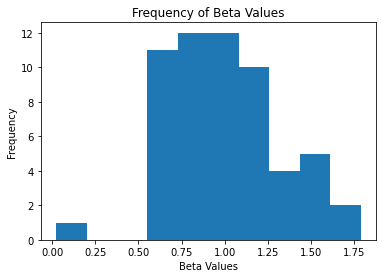

In [40]:
# Plot the histogram
plt.hist(stats_df['beta'])

# Title and Axes Labels
plt.title('Frequency of Beta Values')
plt.xlabel('Beta Values')
plt.ylabel('Frequency')

plt.show()

From the graph above, we can see that most of our beta values lie around the 1.0 mark, which makes sense because that's the average market movement; you'd expect most stocks to move roughly similarly to the market, as otherwise the market would not be moving in that direction. 

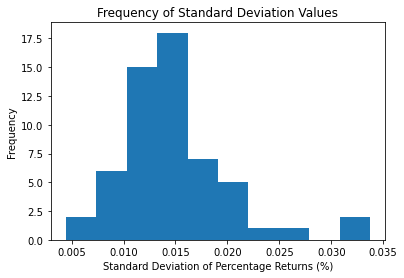

In [41]:
# Plot the histogram
plt.hist(stats_df['std'])

# Title and Axes Labels
plt.title('Frequency of Standard Deviation Values')
plt.xlabel('Standard Deviation of Percentage Returns (%)')
plt.ylabel('Frequency')

plt.show()

 In the graph above, you can see a histogram of the standard deviation of percentage returns on all of our stocks. We want to select the stocks with the smallest values, and avoid those on the upper end of the spectrum, since we want to avoid having too much risk in our portfolio. 

## Point System

Since we have two different measures for risk and stock volatility, we needed a way to combine them together a low beta didn't necessarily mean a low standard deviation, and the same for the other way around. We didn't necessarily want to prioritize one over the other by filtering our stocks by one statistic before filtering by the other, so we decided on a points system. We would sort all our stocks based on standard deviation, and again by beta, going from smallest to largest. Then, we gave points to each stock depending on where they ranked in our sorted list, giving the stock with the lowest standard deviation and lowest beta the highest number of points, and those with the highest values the lowest number of points. Then, we added those points together and resorted the series to get the final list of stocks from safest to riskiest, based purely on beta and standard deviation.

## Diversification


As we learned from Assignment 3, diversification reduces the overall risk of a portfolio. So, when we choose the stocks with the highest number of points based on standard deviation and beta, we also need to consider the industries that the stocks are from. Even if some stocks have low standard deviation and beta values, we must consider the industry that they are a part of. Thus, we have implemented a process that selects stocks based on standard deviation and beta values, while also taking into account the importance of diversification across industries. After a select number of stocks have been chosen from an industry, we no longer add the next stock from that same industry. Instead, we introduce stocks from other industries. This way, if any external event were to affect one particular industry more than the others, our portfolio would overall experience less fluctuations. By accounting for non-systematic risk, we are further ensuring that our final portfolio is safe. 

In [47]:
#Get a pandas series of the beta and sd, sorted in ascending order, then put that in a DataFrame
beta_df = pd.DataFrame(stats_df['beta'].sort_values(ascending=True))
std_df = pd.DataFrame(stats_df['std'].sort_values(ascending=True))

#Now we give each stock points in each category using a list
std_points = []
beta_points = []
for i in range (tickers_num):
    std_points.append(tickers_num - i) #So the stocks with the lowest std get the highest number of points
    beta_points.append(tickers_num - i) #So the stocks with the lowest beta get the highest number of points

#Add our lists to our DataFrames as new columns
beta_df['points'] = beta_points
std_df['points'] = std_points

#Store all the necessary points values we need, adding the points from beta and std together
total_points = pd.DataFrame(std_df['points'])
total_points.columns = ['std']
total_points['beta'] = pd.DataFrame(beta_df['points'])
total_points['total'] = total_points['std'] + total_points['beta']

#Now we isolate the total points and sort that series from highest to lowest before turning it back into a DataFrame
#Since we want to prioritize the stocks with the highest number of total points
final_points = pd.DataFrame(total_points['total'].sort_values(ascending=False))
final_points.reset_index(inplace=True)
final_points.columns = ['tickers', 'points']


In [54]:
selected_tickers = []
sector_count = {}
sector_max = 5

for i in range (tickers_num):
    #We only want choose the maximum number of stocks we can (initiated in the very beginning of the code), not the
    # total number of stocks we have, so if we have enough stocks, do nothing
    if len(selected_tickers) < max_stocks: 
        sector = stocks_full_info[tickers_list[i]]
     
        if sector in sector_count: #If there is a key in sector_count that matches the sector of our stock
            #If our current number of stocks is less than our maximum, then we add it, otherwise we just skip over it
            # and do nothing
            if sector_count[sector] < sector_max: 
                selected_tickers.append(final_points.tickers[i])
                sector_count[sector] += 1
        else: #So if there is no sector in our dictionary that matches that of the stock
            selected_tickers.append(final_points.tickers[i])
            sector_count[sector] = 1


In [57]:
selected_ticker_prices = pd.DataFrame()
selected_portfolio = pd.DataFrame()
selected_ticker_returns = pd.DataFrame()
selected_ticker_points = []
selected_ticker_weights = []
shares_per_stock = []
investment = 500000 #500,000

#Get the number of points associated with each of our chosen tickers
for i in range (len(selected_tickers)):
    selected_ticker_points.append(total_points.total[selected_tickers[i]])

#Calculate the weighting that should be given to each of our selected tickers, based on how their points compare to 
# that of the other chosen stocks
for i in range (len(selected_tickers)):
    selected_ticker_weights.append(selected_ticker_points[i] / sum(selected_ticker_points))
    selected_ticker_prices[selected_tickers[i]] = all_prices[selected_tickers[i]]
    selected_ticker_returns[selected_tickers[i]] = daily_returns[selected_tickers[i]]
    shares_per_stock.append((investment * selected_ticker_weights[i]) / selected_ticker_prices.iloc[0, i])
    selected_portfolio[selected_tickers[i]] = shares_per_stock[i] * selected_ticker_prices[selected_tickers[i]]

selected_portfolio['total'] = selected_portfolio.sum('columns')



## Correlation 
We will calculate the correlation between two stocks, given by the following formula: 
\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

It describes the relationship between two two and how they move together. This calculation is expressed numerically as the correlation coefficient, which has a value between -1 and 1, where 1 represents a perfect positive correlation and -1 represents a perfect negative correlation. When two stocks are postively correlated, it implies that as one stock moves up or down, the other moves in the same direction. Conversely, when two stocks are negatively correlated, it implies that the two move in opposite directions. Zero correlation implies that there is no relationship between the stocks at all. 

Since we are creating a safe portfolio, we wish to reduce risk. Thus, we want to find a negative correlation between our stocks to help counteract any fluctuations within the protfolio. We take the list of stocks that have low standard deviations and betas, so that the overall portfolio is not affected by the volatility of these stocks. We then wish to find the most negatively correlated stocks in that list to discover which best complement the portfolio. Furthermore, the inclusion of negatively correlated stocks is used to account for non-systematic risks. If two stocks are very positively correlated, it is expected that the external event that affected one stock, is likely to affect the other. Therefore, to reduce risk, we include a small number of stocks that have a negative correlation with each other. 

Before we find the correlation, we want to extract the top 30 stocks that was filtered from the point system, earlier.

In [60]:
top_number_of_stocks = 30
top_stocks_returns = pd.DataFrame()
top_stocks_tickers = []

for i in range (top_number_of_stocks):
    top_stocks_tickers.append(final_points['tickers'])
    top_stocks_returns[top_stocks_tickers[i]] = daily_returns[top_stocks_tickers[i]]


Next, we are able to find the correlations between each of these stocks with a correlation matrix: 

In [62]:
corr_matrix = top_stocks_returns.corr()


As seen above, there are multiple repeating and redundant values. We wish to remove these values and ultimately sort through the entire matrix to find the lowest correlations. 

In [63]:
#returns the redundant pairs in the matrix, such as AAPL and AAPL or AAPL and ABBV with AABV and AAPL
def get_redundant_pairs(df):
    to_drop = set()
    cols = df.columns

    #itereate through the rows and the columns to drop any redundant pairs
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            to_drop.add((cols[i], cols[j]))

    return to_drop

def get_neg_correlations(df):
    #unstack to make it easier to read, outputting a series 
    sorted_corr = df.corr().unstack()
    #dropping the redundant pairs 
    to_drop = get_redundant_pairs(df)
    sorted_corr = sorted_corr.drop(labels=to_drop).sort_values(ascending=True)
    return sorted_corr

print("\nNegative Correlations")
neg_corr = pd.DataFrame(get_neg_correlations(top_stocks_returns)).reset_index()
neg_corr.rename(columns = {'level_0':'Ticker 1', 'level_1':'Ticker 2'}, inplace = True)
neg_corr


Negative Correlations


,Ticker 1,Ticker 2,0
0,NEE,OXY,-0.208245
1,PG,OXY,-0.207488
2,SO,OXY,-0.198518
3,NEE,SLB,-0.180216
4,PFE,AXP,-0.162461
...,...,...,...
1591,USB,BAC,0.819622
1592,JPM,USB,0.825209
1593,COP,OXY,0.832766
1594,C,BAC,0.839226


In [64]:
temp = neg_corr.copy()

#Function to remove any instances of a ticker from a DataFrame set up like neg_corr
def remove_instances(ticker1, df):
    #Loop through all rows of the DataFrame
    new_df = df.copy()
    index_to_drop = []
    for i in range (len(df.index)):
        if ticker1 == new_df.iloc[i, 0]:
            index_to_drop.append(i)
        elif ticker1 == new_df.iloc[i, 1]:
            index_to_drop.append(i)
        
    new_df.drop(labels=index_to_drop, axis=0, inplace=True)
    return new_df


In [65]:
#we only want three pairs of stocks from the correlation portfolio
corr_stocks_number = 3 
corr_tickers = []
#create a temporary dataframe
temp_df = neg_corr.copy()
temp_df.reset_index(drop=True, inplace=True)

#loop through the dataframe to extract the stocks with the smallest correlation 
#each time we extract a ticker, we remove all instances of it from the dataframe to ensure that
#there are no repeating tickers and that each pair of tickers offset each other
for i in range (corr_stocks_number):
    
    corr_tickers.append(temp_df.iloc[0, 0])
    tick1 = corr_tickers[2*i]
    
    corr_tickers.append(temp_df.iloc[0, 1])
    
    tick2 = corr_tickers[2*i + 1]
    temp_df = remove_instances(tick1, temp_df)
    temp_df.reset_index(drop=True, inplace=True)
    temp_df = remove_instances(tick2, temp_df)
    temp_df.reset_index(drop=True, inplace=True)

corr_tickers

['NEE', 'OXY', 'PFE', 'AXP', 'ABT', 'COP']

In [66]:
#to help with the Monte Carlo calculations later on
corr_prices = pd.DataFrame() 

for i in range (len(corr_tickers)):
    corr_prices[corr_tickers[i]] = all_prices[corr_tickers[i]]
corr_prices

,NEE,OXY,PFE,AXP,ABT,COP
Date,,,,,,
2021-03-16,72.760925,27.906591,33.452473,139.840637,114.442245,52.356480
2021-03-17,70.425011,28.768456,33.415127,141.187302,113.861427,52.587826
2021-03-18,68.658592,26.371084,33.396461,139.138016,114.335777,49.395359
2021-03-19,68.378662,27.837244,33.172375,137.313156,116.407379,48.673565
2021-03-22,69.199142,27.203228,33.611195,136.571503,117.588394,48.340450
...,...,...,...,...,...,...
2021-12-22,88.903595,28.680225,57.152184,159.835724,136.080063,67.193993
2021-12-23,88.805687,28.610804,56.346008,161.527832,136.246490,67.297981
2021-12-29,90.068741,29.017406,55.261509,161.173676,138.233994,68.933380


In [67]:
corr_prices = pd.DataFrame() 

for i in range (len(corr_tickers)):
    corr_prices[corr_tickers[i]] = all_prices[corr_tickers[i]]
corr_prices

,NEE,OXY,PFE,AXP,ABT,COP
Date,,,,,,
2021-03-16,72.760925,27.906591,33.452473,139.840637,114.442245,52.356480
2021-03-17,70.425011,28.768456,33.415127,141.187302,113.861427,52.587826
2021-03-18,68.658592,26.371084,33.396461,139.138016,114.335777,49.395359
2021-03-19,68.378662,27.837244,33.172375,137.313156,116.407379,48.673565
2021-03-22,69.199142,27.203228,33.611195,136.571503,117.588394,48.340450
...,...,...,...,...,...,...
2021-12-22,88.903595,28.680225,57.152184,159.835724,136.080063,67.193993
2021-12-23,88.805687,28.610804,56.346008,161.527832,136.246490,67.297981
2021-12-29,90.068741,29.017406,55.261509,161.173676,138.233994,68.933380


In [73]:
corr_portfolio = pd.DataFrame()
corr_ticker_cost = investment / (corr_stocks_number * 2)
corr_shares_per_stock = []

for i in range (len(corr_tickers)):
    corr_shares_per_stock.append(corr_ticker_cost / corr_prices.iloc[0, i])
    corr_portfolio[corr_tickers[i]] = corr_shares_per_stock[i] * corr_prices[corr_tickers[i]]

corr_portfolio['total'] = corr_portfolio.sum('columns')


In [69]:
# Monte Carlo Simulation
# Input: list with both weighted portfolio historical prices
def monte_carlo(portfolio_value):
    daily_returns = np.diff(portfolio_value)/100
    daily_volatility = portfolio_value.std()

    num_simulations =  2000
    df = pd.DataFrame()

    trading_days = 5
    price = portfolio_value[len(portfolio_value)-1]/2000
    price_list = []

    for i in range(num_simulations): 
        for i in range(trading_days):
            if i == trading_days-1:
                price_list.append(price/2)
                price=0
                break
            price = price/2000 * (1 + np.random.normal(0, daily_volatility))
            print(price)
        price = portfolio_value[len(portfolio_value)-1]/2000

    mean_simulated_price = round(np.mean(price_list),2)

    return mean_simulated_price

In [ ]:
ranking_weight =[]
correlation_weight=[]
predicted_price=[]

count = 70
while count <= 95:
    ranking_weight.append(count/100)
    correlation_weight.append((100-count)/100)
    
    ranking_weighted_value = [x * count/100 for x in selected_portfolio['total']]
    correlation_weighted_value = [x * ((100-count)/100) for x in corr_portfolio['total']]

    predicted_price.append(monte_carlo(np.add(ranking_weighted_value, correlation_weighted_value)))

    count += 5
# Create a dataframe to store Monte Carlo values
monte_carlo_df = pd.DataFrame()

# Convert python lists to numpy arrays
ranking_weight_array = np.array(ranking_weight) 
correlation_weight_array = np.array(correlation_weight)
predicted_price_array = np.array(predicted_price)

# Populating the dataframe storing sharpe ratio values and weightings
monte_carlo_df['Correlation Stocks Percentage'] = ranking_weight_array*100
monte_carlo_df['SD/Beta Stocks Percentage'] = correlation_weight_array*100
monte_carlo_df['Monte Carlo Prediction'] = predicted_price_array

In [78]:
# Function finds the minimum value in magnitude
def get_min_absvalue(values):
    return min(values, key = abs)
    
values = monte_carlo_df.iloc[:,2]
min_absvalue = get_min_absvalue(values)



In [79]:
corr_stock_weighting = monte_carlo_df['Correlation Stocks Percentage'][0]
stat_stock_weighting = monte_carlo_df['SD/Beta Stocks Percentage'][0]

corr_stocks_amount = corr_stocks_number * 2
def combine_portfolios(df1, df2, df1_tickers, df2_tickers):
    #Prioritize df1, that's the one we definitely keep all the stocks from, df2 used to supplement
    final_df = pd.DataFrame()
    for i in range (max_stocks):
        if i < len(df1_tickers):
            final_df[df1_tickers[i]] = df1[df1_tickers[i]]
        else: 
            for j in range (corr_stocks_amount):
                if df2_tickers[j] not in final_df.columns:
                    final_df[df2_tickers[j]] = df2[df2_tickers[j]]
                    break
    
    return final_df

In [80]:
corr_stocks_amount = corr_stocks_number * 2
def combine_portfolios(df1, df2, df1_tickers, df2_tickers):
    #Prioritize df1, that's the one we definitely keep all the stocks from, df2 used to supplement
    final_df = pd.DataFrame()
    count = 0
    for i in range (max_stocks):
        if i < len(df1_tickers):
            final_df[df1_tickers[i]] = df1[df1_tickers[i]]
        
        elif df2_tickers[count] not in final_df.columns:
            final_df[df2_tickers[count]] = df2[df2_tickers[count]]
            count += 1
        elif df2_tickers[count+1] not in final_df.columns:
            final_df[df2_tickers[count+1]] = df2[df2_tickers[count+1]]
            count += 2
        elif df2_tickers[count+2] not in final_df.columns:
            final_df[df2_tickers[count+2]] = df2[df2_tickers[count+2]]
            count += 3
        elif df2_tickers[count+3] not in final_df.columns:
            final_df[df2_tickers[count+3]] = df2[df2_tickers[count+3]]
            count += 4
        elif df2_tickers[count+4] not in final_df.columns:
            final_df[df2_tickers[count+4]] = df2[df2_tickers[count+4]]
            count += 5
        elif df2_tickers[count+5] not in final_df.columns:
            final_df[df2_tickers[count+5]] = df2[df2_tickers[count+5]]
            count += 6
    
    return final_df

In [81]:
final_portfolio = combine_portfolios(corr_prices, selected_portfolio, corr_tickers, selected_tickers)
final_tickers = list(final_portfolio.columns)
final_tickers_df = pd.DataFrame(selected_tickers)
final_tickers_df.columns = ['tickers']
stdbeta_tickers = final_tickers_df.loc[final_tickers_df['tickers'].isin(final_tickers[corr_stocks_amount : len(final_tickers)])]


stdbeta_tickers


,tickers
0,MON
1,PG
2,BMY
3,CL
4,KO
5,COST
6,RY.TO
7,ABBV
8,PEP
9,TD.TO


In [83]:
Portfolio_Final = pd.DataFrame()
current_date = '2022-11-25'
current_date_end = '2022-11-26'
portfolio_prices = []

for i in range (len(final_tickers)):
    portfolio_prices.append(get_closing_prices(final_tickers[i], current_date, current_date_end).iloc[0])



In [84]:
index_list = [*range(1, len(final_tickers) + 1)]
for i in range (len(final_tickers)):
    Portfolio_Final['Ticker'] = final_tickers
    final_shares = []
    final_value = []
    final_weight = []
    for j in range (len(final_tickers)):
        if j < corr_stocks_amount:
            #corr_stocks_amount is the total number of stocks we have in our correlation portfoliio
            #corr_stock_weighting is the percentage of our final portfolio that will consist of our correlation stocks
            final_weight.append(corr_stock_weighting / corr_stocks_amount)
            final_value.append(final_weight[j] * investment)
            final_shares.append(final_value[j] / portfolio_prices[j])
        else:
            #selected_ticker_weights is a list of all the weightings we gave to each individual stock in the initial
            # selected_portfolio (based on std and beta)
            final_weight.append(stat_stock_weighting * selected_ticker_weights[stdbeta_tickers.index[stdbeta_tickers['tickers'] == final_tickers[j]].tolist()[0]])
            final_value.append(final_weight[j] * investment)
            final_shares.append(final_value[j] / portfolio_prices[j])
    
    final_shares = final_shares / sum(final_weight)
    final_value = final_value / sum(final_weight)
    final_weight = final_weight / sum(final_weight)
    Portfolio_Final['Price'] = portfolio_prices
    Portfolio_Final['Shares'] = final_shares
    Portfolio_Final['Value'] = final_value
    Portfolio_Final['Weight'] = final_weight
    Portfolio_Final['index'] = index_list
    Portfolio_Final = Portfolio_Final.set_index('index')

Portfolio_Final

,Ticker,Price,Shares,Value,Weight
index,,,,,
1,NEE,85.339996,728.239449,62147.951871,0.124296
2,OXY,70.136589,886.098864,62147.951871,0.124296
3,PFE,48.762337,1274.507254,62147.951871,0.124296
4,AXP,153.617523,404.562908,62147.951871,0.124296
5,ABT,106.477898,583.669975,62147.951871,0.124296
6,COP,125.465149,495.340359,62147.951871,0.124296
7,MON,10.010000,854.060429,8549.145085,0.017098
8,PG,145.805069,54.005067,7874.212579,0.015748
9,BMY,78.618034,99.203957,7799.220078,0.015598


In [85]:
print("Total Portfolio Weight: ", np.round(Portfolio_Final['Weight'].sum() * 100, 2), "%", sep='')
print("Total Portfolio Value: $", np.round(Portfolio_Final['Value'].sum(), 2), sep='')

Total Portfolio Weight: 100.0%
Total Portfolio Value: $500000.0


In [86]:
Stocks_Final = Portfolio_Final.filter(['Ticker', 'Shares'], axis=1)

Stocks_Final.to_csv('Stocks_Group_03.csv')

In [87]:
final_prices = pd.DataFrame()
for i in range (len(final_tickers)):
    final_prices[final_tickers[i]] = all_prices[final_tickers[i]] * Stocks_Final.iloc[i, 1]

final_prices['total'] = final_prices.sum('columns')
final_prices

,NEE,OXY,PFE,AXP,ABT,COP,MON,PG,BMY,CL,...,PM,T,SO,MO,CVS,TGT,LMT,UNP,MRK,total
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-16,52987.376111,24727.998947,42635.419094,56574.334816,66796.502577,25934.277407,8357.152207,6626.420783,5773.224941,7326.482856,...,5223.057198,6461.864021,5251.434764,5820.273695,4270.367293,6335.103602,4079.306857,5195.762705,3446.343320,374263.837323
2021-03-17,51286.270942,25491.695738,42587.821491,57119.145294,66457.496446,26048.872482,8267.305209,6599.696778,5799.340228,7320.689400,...,5282.276793,6496.338869,5204.279322,5860.299357,4210.068391,6271.475202,4125.019400,5210.488517,3468.329693,373359.719353
2021-03-18,49999.895339,23367.387760,42564.032413,56290.080236,66734.360285,24467.514864,8344.170778,6614.087609,5813.329763,7346.765360,...,5362.814500,6466.174014,5178.557689,5953.301344,4236.805851,6314.010687,4212.333786,5285.589924,3466.983503,368103.202266
2021-03-19,49796.039186,24666.550311,42278.432210,55551.809722,67943.492096,24109.981101,8327.089179,6578.626183,5847.839074,7241.493624,...,5356.211931,6412.306427,5118.541607,5950.946156,4162.854437,6593.134357,4172.613443,5173.673988,3477.751880,368943.817510
2021-03-22,50393.545342,24104.749421,42837.711337,55251.764248,68632.815100,23944.975984,8284.385994,6690.145543,5911.260293,7317.790354,...,5400.022691,6461.864021,5117.683972,6079.264996,4179.351147,6610.359346,4203.050090,5062.493642,3477.751880,370411.656523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-22,64743.104975,25413.515117,72840.872478,64663.605221,79425.846911,33283.896403,8327.089179,8343.307437,5928.092995,8100.642337,...,5791.020001,5738.628501,5892.620396,5929.501469,5846.134719,7731.978038,4122.860191,6047.711693,3678.930991,460751.404715
2021-12-23,64671.804492,25352.000567,71813.396297,65348.169416,79522.985711,33335.406177,8327.089179,8384.154867,5923.320954,8133.062519,...,5792.266223,5759.472142,5882.895210,5906.734305,5869.889618,7848.095970,4169.478865,6116.184619,3658.159575,460873.546382
2021-12-29,65591.610163,25712.290899,70431.193997,65204.890835,80683.031568,34145.485238,8344.170778,8598.340797,5946.231292,8341.324141,...,5877.658480,5706.207609,6018.164312,5995.272347,6008.365950,8093.471199,4256.588167,6250.389395,3717.091802,464656.840676


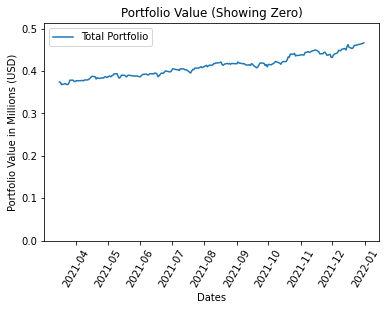

In [88]:
#Graphs of the std/beta portfolio, without correlation stocks
#so that the graph will not automatically be in scientific notation
interval = ['Millions', 1000000] #First element is the name, second element is the number

#Graph the selected portfolio value
plt.plot(final_prices.index, final_prices['total'] / interval[1], label='Total Portfolio')

plt.title('Portfolio Value (Showing Zero)')
plt.xlabel('Dates')
plt.xticks(rotation=60)
plt.ylabel('Portfolio Value in ' + interval[0] + ' (USD)')
#Show zero so that we can get a more accurate idea of how much the portfolio value changed overall, in the grand 
# scheme of things
plt.ylim([0, max(final_prices['total'] / interval[1]) + 0.1 * max(final_prices['total'] / interval[1])])
plt.legend(loc='best')

plt.show()

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

- Ifan Zhao

- Sherry Feng

- Kelly Wang